In [1]:
import sys
import os
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt


from ControlRF import ADPController, ADController

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/core")

import core
from core.controllers import QPController
from core.dynamics import AffineDynamics, AffineQuadCLF, ScalarDynamics, SystemDynamics, RoboticDynamics
from core.util import arr_map
from core.controllers import FBLinController, LQRController
from core.systems import InvertedPendulum, DoubleInvertedPendulum


In [5]:
def plot_simulation(system, controller, x_0,
					T=20, num_steps=200):
	ts = np.linspace(0, T, num_steps + 1)
	xs, us = system.simulate(x_0, controller, ts)

	ax = plt.figure(figsize=(8, 6), tight_layout=True).add_subplot(1, 1, 1)
	ax.set_xlabel('$t$', fontsize=16)
	ax.plot(ts, xs[:,0], '-', label='theta')
	ax.plot(ts, xs[:,1], '-', label='theta dot')
	ax.plot(ts[1:], us, '-', label='input')

	ax.legend(fontsize=16)
	ax.grid()

	ax = plt.figure(figsize=(8, 6), tight_layout=True).add_subplot(1, 1, 1)
	ax.set_xlabel('$\\theta$', fontsize=16)
	ax.set_ylabel('$\dot \\theta$', fontsize=16)
	ax.plot(xs[:,0], xs[:,1], '-')
	ax.grid()

In [6]:
def main_invp(plot=False): #d=1
    system = InvertedPendulum(0.7,0.7)
    system_est = InvertedPendulum(0.50,0.5)
    lyap_est = AffineQuadCLF.build_care(system_est, Q=np.identity(2), R=np.identity(1))
    
    alpha = 1 / max(la.eigvals(lyap_est.P))
    
    # Nominal Controller Static Slacked
    controller = QPController(system_est, system.m)
    controller.add_static_cost(np.identity(1))
    controller.add_stability_constraint(lyap_est, comp=lambda r: alpha * r, slacked=True, coeff = 1e3)
    
    x_0 = np.array([2, 0.1])
    ad_controller = ADController(system_est, system, controller, lyap_est, x_0, 100, 1000, estimate=False)
    ad_controller.add_static_cost(np.identity(1))
    ad_controller.add_stability_constraint(lyap_est, comp=alpha, slacked=True, beta = 1, coeff=1e5)
    
    x_0 = np.array([1, 0.1])
    
    if plot:
        #plot_simulation(system, controller, x_0)
        plot_simulation(system, ad_controller, x_0, T=100, num_steps=1000)


In [4]:
class SetPointOutput(RoboticDynamics):
    def __init__(self, robotic_dynamics, q_d):
        RoboticDynamics.__init__(self, robotic_dynamics.k, robotic_dynamics.m)
        self.robotic_dynamics = robotic_dynamics
        self.q_d = q_d
        
    def eval(self, x, t):
        q, q_dot = np.reshape(x, (2, -1))
        return np.concatenate([q - self.q_d, q_dot])
        
    def drift(self, x, t):
        return self.robotic_dynamics.drift(x, t)
    
    def act(self, x, t):
        return self.robotic_dynamics.act(x, t)

In [5]:
def main_double_invp(plot=True):
    system = DoubleInvertedPendulum(0.25,0.25,.7,0.7)
    system_est = DoubleInvertedPendulum(0.5,0.5,0.5,0.5)
    Q , R = 10*np.identity(4), np.identity(2)
    q_d = np.array([-1, 0])
    set_point = SetPointOutput(system_est, q_d)
    lyap_est = AffineQuadCLF.build_care(set_point, Q, R)
        
    alpha = min(la.eigvalsh(Q)) / max(la.eigvalsh(lyap_est.P))
    
    # Nominal Controller Static Slacked
    # controller = QPController.build_care(system_est,Q ,R)
    controller = QPController(system, 2)
    controller.add_stability_constraint(lyap_est, comp=lambda r: alpha * r, slacked=True, coeff = 1e5)
    

    # lqr = LQRController.build(set_point, Q, R)
    # fb_lin = FBLinController(set_point, lqr)
    # qp.add_regularizer(fb_lin, 1)


    x_0 = np.array([1, 0, 0, 0])
    adp_controller = ADPGPController(system_est, system, controller, lyap_est, x_0, 20, 200, estimate=False)
    adp_controller.add_static_cost(np.identity(2))
    adp_controller.add_stability_constraint(lyap_est, comp=alpha, slacked=True, beta = 1, coeff=1e3)
    
    if plot:
        plot_simulation(system, controller, x_0)
        plot_simulation(system, adp_controller, x_0, T=20, num_steps=200)

----------------------------training finished------------------------------


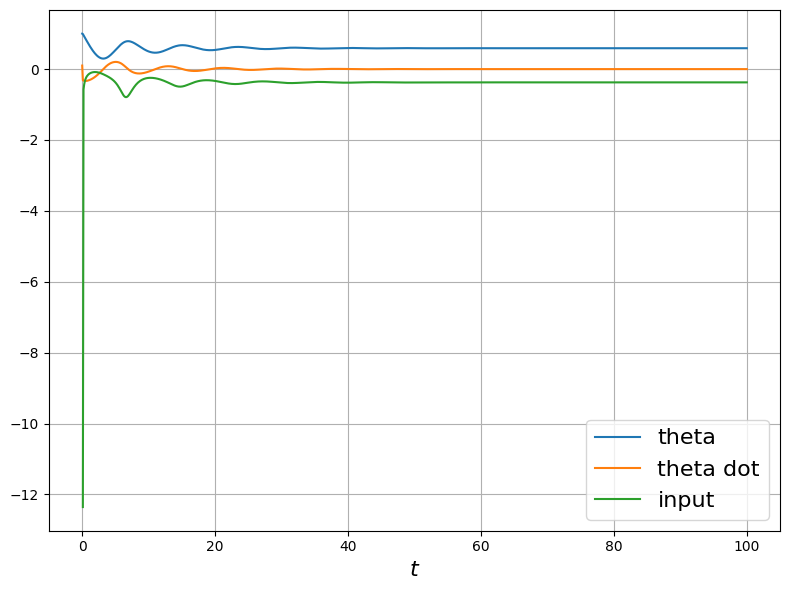

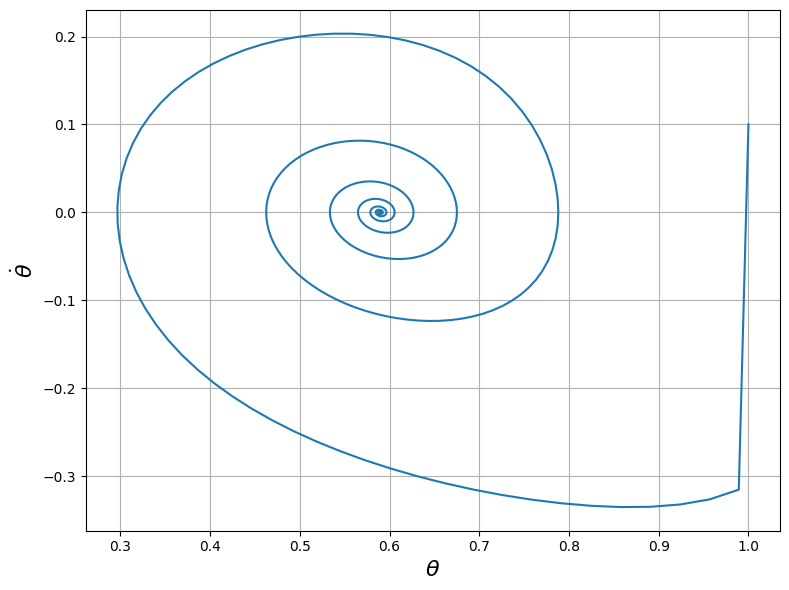

In [7]:
main_invp(plot=True)
#main_double_invp()